In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time

In [0]:
# Creating and converting dataset to tensorflow
path = tf.keras.utils.get_file('dracula.txt', 'http://www.gutenberg.org/cache/epub/345/pg345.txt')
text = open(path, 'rb').read().decode(encoding='utf-8')
vocabulary = sorted(set(text))
vocabulary_size = len(vocabulary)

In [14]:
# map unique characters to indices and vice versa
charMapping = {u:i for i, u in enumerate(vocabulary)}
indiceMapping = np.array(vocabulary)
text_as_int = np.array([charMapping[c] for c in text])

sequence_length = 100
examples_per_epoch = len(text)//sequence_length # floor division
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(sequence_length+1, drop_remainder=True)

num_of_characters = len(text)
num_of_vocabulary = len(vocabulary)
print("Total Characters: ", num_of_characters)
print("Total Vocabulary: ", num_of_vocabulary)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

Total Characters:  883114
Total Vocabulary:  102


In [0]:
BATCH_SIZE = 128
steps_per_epoch = examples_per_epoch//BATCH_SIZE # floor division
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [0]:
# Build model
embedding_dimension = 256
rnn_units = 1024

lstm = tf.keras.layers.CuDNNLSTM # fast LSTM implementation backed by cuDNN
gru = tf.keras.layers.CuDNNGRU # fast LSTM implementation backed by cuDNN

def build_model(vocab_size, embedding_dim, units, batch_size, drop_out):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]), # Input layer
    gru(rnn_units, # Hidden layer 1
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    gru(rnn_units, # Hidden layer 2
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    gru(rnn_units, # Hidden layer 3
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    gru(rnn_units, # Hidden layer 4
        return_sequences=True, 
        recurrent_initializer='lecun_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size) # Output layer
  ])
  return model

model = build_model(
  vocab_size = vocabulary_size, 
  embedding_dim=embedding_dimension, 
  units=rnn_units, 
  batch_size=BATCH_SIZE,
  drop_out=0.2)

In [0]:
# Validate the model
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [18]:
# Train the model
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

model.compile(tf.train.AdamOptimizer(), loss=loss)

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS=100
history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Prediction shape:  (128, 100, 102)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.62594
Epoch 1/100
68/68 [==============================] - 36s 535ms/step - loss: 3.2739
Epoch 2/100
68/68 [==============================] - 37s 546ms/step - loss: 2.3937
Epoch 3/100
68/68 [==============================] - 39s 566ms/step - loss: 1.9828
Epoch 4/100
68/68 [==============================] - 39s 566ms/step - loss: 1.7173
Epoch 5/100
68/68 [==============================] - 38s 564ms/step - loss: 1.5497
Epoch 6/100
68/68 [==============================] - 39s 568ms/step - loss: 1.4416
Epoch 7/100
68/68 [==============================] - 39s 567ms/step - loss: 1.3676
Epoch 8/100
68/68 [==============================] - 38s 565ms/step - loss: 1.3125
Epoch 9/100
68/68 [==============================] - 39s 569ms/step - loss: 1.2663
Epoch 10/100
68/68 [==============================] - 38s 564ms/step - loss: 1.2279
Epoch 11/100
68/68 [==============================] - 39s 571m

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocabulary_size, embedding_dimension, rnn_units, batch_size=1, drop_out=0.2)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
# Generate text algorithm
def generate_text(model, num_char_to_generate, temperature, start_string):
  # Converting our start string to numbers (vectorizing) 
  input_eval = [charMapping[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  for i in range(num_char_to_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(indiceMapping[predicted_id])

  return (start_string + ''.join(text_generated))

In [21]:
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.

print(generate_text(model, 5000, .6, "Dracula moved to Copenhagen because "))

Dracula moved to Copenhagen because in order that he has placed the floor. The instant he seemed as though he would open the door 'isself an' 'elped me,
and r that a sudden glimpse of the angle of the building, and the light fell
on the window. There distinctly was Lucy with her now how to conter last horribly weak. My face is being
soall, and had to go round headstones and railed---

CHAPTER X

Jressed for his answer. I was afraid to speak or move. The time is
still some day and nights principles of him which we are on fine and worn out what it is possed
into the room where was no mapit once, and he must have sunk down but a constant
sufferens from a road and say:--

"This is the way."

"How know you it?" I ask.

"Of course I know you praise from your letters to Mina, for
to her I could speak for quite like to oblige him to east and softly. She has got the child and said:--

"Brave lad! A moment's courage, and returned with the decanter.
He wetted the pointer to the port and saw that 

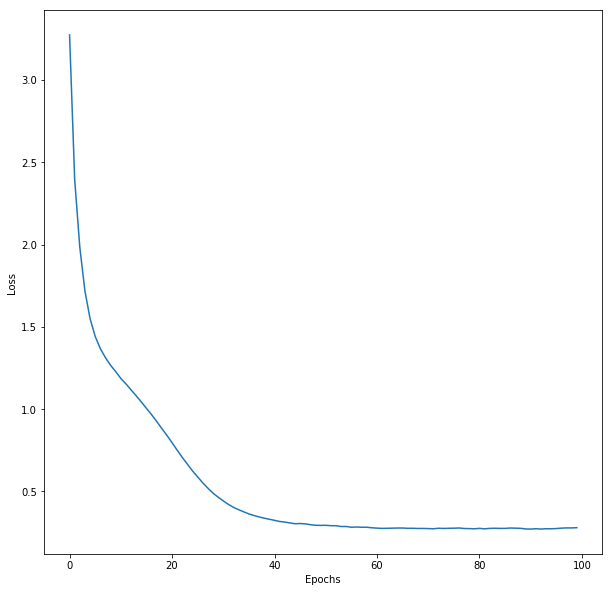

In [22]:
import matplotlib.pyplot as plt
import numpy as np
loss = history.history['loss']
newLoss = np.squeeze(loss)
plt.figure(figsize=(10,10))
plt.plot(newLoss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()